In [1]:
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader, random_split
import torch.optim as optim
import numpy as np
import torch
import torch.nn.init as init
import torch.nn.functional as F
import matplotlib.pyplot as plt
from source.Data_generation import IRF, equidistant_interpolation, c_tissue, simulated_tac
from source.Plots import *

In [2]:
def IRF_torch(gt_parameters_tensor, equidistant_rtim_tensor):
    """
    Calculates the impulse response function (IRF) for the given parameters and equidistant timepoints using PyTorch.

    Parameters:
    gt_parameters_tensor (torch.Tensor): Tensor of parameters.
    equidistant_rtim_tensor (torch.Tensor): Tensor of equidistant timepoints.

    Returns:
    torch.Tensor: The IRF values.
    """
    # Given that gt_parameters_tensor shape is [batch_size, 4]
    k1, k2, k3 = gt_parameters_tensor[:, 0], gt_parameters_tensor[:, 1], gt_parameters_tensor[:, 2]
    k4 = torch.zeros_like(k1)  # Ensuring k4 is the same shape and device as k1

    # Calculate alphas for the entire batch
    alpha1 = (k2 + k3 + k4) - torch.sqrt((k2 + k3 + k4)**2 - 4*k2*k4)
    alpha1 /= 2
    alpha2 = (k2 + k3 + k4) + torch.sqrt((k2 + k3 + k4)**2 - 4*k2*k4)
    alpha2 /= 2

    # Calculate IRF for each time point and each batch
    epsilon = 1e-8
    equidistant_rtim_tensor = equidistant_rtim_tensor.unsqueeze(0)  # Adding a batch dimension for broadcasting
    value = ((k3 + k4 - alpha1).unsqueeze(1) * torch.exp(-alpha1.unsqueeze(1) * equidistant_rtim_tensor) + 
             (alpha2 - k3 - k4).unsqueeze(1) * torch.exp(-alpha2.unsqueeze(1) * equidistant_rtim_tensor)) / (alpha2 - alpha1 + epsilon).unsqueeze(1)
    
    IRF = value * k1.unsqueeze(1)  # Ensuring k1 is correctly broadcasted over the time dimension

    return IRF


def c_tissue_torch(IRF_tensor, pchip_tensor, dt):
    """
    Calculates the simulated C_Tissue values for the given IRF and plasma concentration values using PyTorch.
    This version ensures that inputs and kernels are properly shaped for PyTorch's conv1d.

    Parameters:
    IRF_tensor (torch.Tensor): The IRF values as a tensor.
    pchip_tensor (torch.Tensor): Plasma concentration values as a tensor, interpolated using PCHIP or equivalent.
    dt (float): The time step increment.

    Returns:
    torch.Tensor: The simulated C_Tissue values as a tensor.
    """
    # Ensure tensors have the correct shape (Batch, Channel, Length)
    if IRF_tensor.dim() == 1:
        IRF_tensor = IRF_tensor.unsqueeze(0).unsqueeze(0)
    elif IRF_tensor.dim() == 2:
        IRF_tensor = IRF_tensor.unsqueeze(1)

    if pchip_tensor.dim() == 1:
        pchip_tensor = pchip_tensor.unsqueeze(0).unsqueeze(0)
    elif pchip_tensor.dim() == 2:
        pchip_tensor = pchip_tensor.unsqueeze(1)

    # Perform 1D convolution. Flip the IRF tensor because PyTorch's conv1d performs cross-correlation.
    padding_size = (IRF_tensor.size(-1) - 1)
    simulated_c_tissue_values = F.conv1d(pchip_tensor, IRF_tensor.flip(dims=[-1]), padding=padding_size)[:,:,:pchip_tensor.size(-1)]

    # Normalize the convolution result by multiplying by dt
    normalized_result_tensor = simulated_c_tissue_values * dt

    # Remove unnecessary batch and channel dimensions before returning
    return normalized_result_tensor.squeeze()


def simulated_tac_torch(c_tissue, gt_parameters, bl_tensor):
    """
    Calculates the simulated TAC values for the given C_Tissue and blood concentration values using PyTorch.

    Parameters:
    c_tissue (torch.Tensor): The C_Tissue values with shape [batch_size, num_points].
    gt_parameters (torch.Tensor): The ground truth parameters with shape [batch_size, num_params].
    bl_tensor (torch.Tensor): Blood concentration values with shape [num_points].

    Returns:
    torch.Tensor: The simulated TAC values with shape [batch_size, num_points].
    """
    # Extracting the 'vb' parameter from the ground truth parameters, assuming it is the fourth parameter
    # The shape of vb is [batch_size, 1] after unsqueezing
    vb = gt_parameters[:, 3].unsqueeze(1)

    # Broadcasting 'vb' and 'bl_tensor' across the batch size and num_points, respectively, for efficient computation
    simulated_tac_values = c_tissue * (1 - vb) + vb * bl_tensor

    return simulated_tac_values

<h3>IRF<h3>

We will check the TAC loss step by step. The TAC is calculated as a sequence of operations (IRF, convolution, and tac calculation), so if there is an issue at the first step it will cascade down to the rest. Thus, we first start by examining the IRF function. For this we change the TAC loss equation to compare the generated IRF signal with the input (an IRF signal in this case):

In [14]:
def irf_loss(predicted_param, inputs, num_equidistant_points = 2048):
    """
    Calculate the loss between the true and predicted TAC values.

    Parameters:
    true_param (torch.Tensor): True parameter values
    predicted_param (torch.Tensor): Predicted parameter values
    num_equidistant_points (int): Number of equidistant points to interpolate the plasma and blood concentration values

    Returns:
    torch.Tensor: Mean squared error between the true and predicted TAC values
    """
    # Fixed data values
    rtim_list = [0.125, 0.291667, 0.375, 0.458333, 0.583333, 0.75, 0.916667, 1.5, 2.5, 3.5, 4.5, 6.25, 8.75, 12.5, 
                 17.5, 25, 35, 45, 55, 65, 75, 85]
    pl_list = [0.05901, 0.0550587, 110.023, 83.0705, 55.6943, 44.4686, 36.9873, 27.5891, 13.5464, 6.33916, 3.52664, 
               2.49758, 1.44494, 1.04103, 0.71615, 0.52742, 0.43791, 0.35239, 0.32866, 0.27326, 0.26068, 0.24129]
    bl_list = [0.08737, 0.081723, 164.763, 125.181, 84.5654, 68.4428, 58.1711, 44.4919, 24.3138, 14.0272, 9.47834, 
               7.88443, 5.59859, 4.81384, 3.79608, 3.04436, 2.67881, 2.23747, 2.13455, 1.80559, 1.74821, 1.63998]

    # Interpolate plasma and blood concentration values
    new_rtim, _, _, pchip_pl = equidistant_interpolation(rtim_list, pl_list, num_equidistant_points)
    _, _, _, pchip_bl = equidistant_interpolation(rtim_list, bl_list, num_equidistant_points)

    # Convert the interpolated plasma and blood concentration values to PyTorch tensors
    pchip_pl_tensor = torch.tensor(pchip_pl, dtype=torch.float32)
    pchip_bl_tensor = torch.tensor(pchip_bl, dtype=torch.float32)
    new_rtim_tensor = torch.tensor(new_rtim, dtype=torch.float32)

    # Find new_rtim values that are closest to the original time points
    closest_indices = [np.argmin(np.abs(new_rtim - t)) for t in rtim_list]
    
    # Calculate the impulse response functions:
    pred_irf = IRF_torch(predicted_param, new_rtim_tensor)

    # Calculate the C-Tissue values
    dt = new_rtim[1] - new_rtim[0]
    pred_c_tissue = c_tissue_torch(pred_irf, pchip_pl_tensor, dt)

    # # Prints to understand the shapes of the tensors
    # print("pred_c_tissue:", pred_c_tissue.shape)
    # print("pred para:", predicted_param.shape)
    # print("inputs:", inputs.shape)

    # Calculate the simulated TAC values
    pred_tac = simulated_tac_torch(pred_c_tissue, predicted_param, pchip_bl_tensor)

    return nn.MSELoss()(pred_irf, inputs)

Taking the mean of each parameter's ranges, now we try to generate a IRF function with them and then use the IRF loss for the same parameters to see if the loss is zero (as it should).

original irf shape: torch.Size([1, 2048])
MSE between IRF signals: tensor(2.6270e-16)


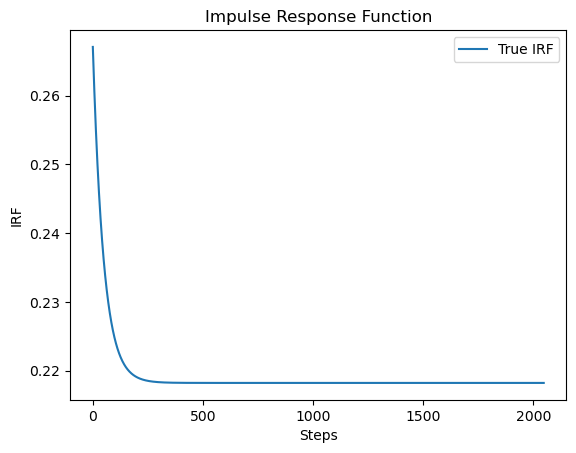

In [20]:
from source.Data_generation import equidistant_interpolation, IRF, c_tissue
rtim_list = [0.125, 0.291667, 0.375, 0.458333, 0.583333, 0.75, 0.916667, 1.5, 2.5, 3.5, 4.5, 6.25, 8.75, 12.5, 
                 17.5, 25, 35, 45, 55, 65, 75, 85]
pl_list = [0.05901, 0.0550587, 110.023, 83.0705, 55.6943, 44.4686, 36.9873, 27.5891, 13.5464, 6.33916, 3.52664, 
               2.49758, 1.44494, 1.04103, 0.71615, 0.52742, 0.43791, 0.35239, 0.32866, 0.27326, 0.26068, 0.24129]
bl_list = [0.08737, 0.081723, 164.763, 125.181, 84.5654, 68.4428, 58.1711, 44.4919, 24.3138, 14.0272, 9.47834, 
               7.88443, 5.59859, 4.81384, 3.79608, 3.04436, 2.67881, 2.23747, 2.13455, 1.80559, 1.74821, 1.63998]
num_equidistant_points = 2048

# Interpolate plasma and blood concentration values
new_rtim, _, _, pchip_pl = equidistant_interpolation(rtim_list, pl_list, num_equidistant_points)
_, _, _, pchip_bl = equidistant_interpolation(rtim_list, bl_list, num_equidistant_points)

p_parameters = np.array([0.27, 0.089, 0.375, 0.228]) # Predicted parameters
t_parameters = np.array([0.27, 0.089, 0.375, 0.228]) # True parameters 
irf = IRF(t_parameters, new_rtim)

# Plot the IRF
plt.plot(irf)
plt.xlabel("Steps")
plt.ylabel("IRF")
plt.title("Impulse Response Function")
plt.legend(["True IRF"])

# Reshape 'parameters' to add a batch dimension
p_parameters_tensor = torch.tensor(p_parameters[np.newaxis, :], dtype=torch.float32)
irf_tensor = torch.tensor(irf, dtype=torch.float32).unsqueeze(0)
print("original irf shape:", irf_tensor.shape)

result = irf_loss(p_parameters_tensor, irf_tensor, num_equidistant_points=2048)
print("MSE between IRF signals:",result)

Seeing that the IRF loss function works correctly, we also try to see if it works for different parameter combinations. For this, we take one estimated parameter, and change its values within its range, to see how the loss increases; the rest of the parameters remain constant and correct. This is done three times per parameter: for its minimum, median, and maximum. 

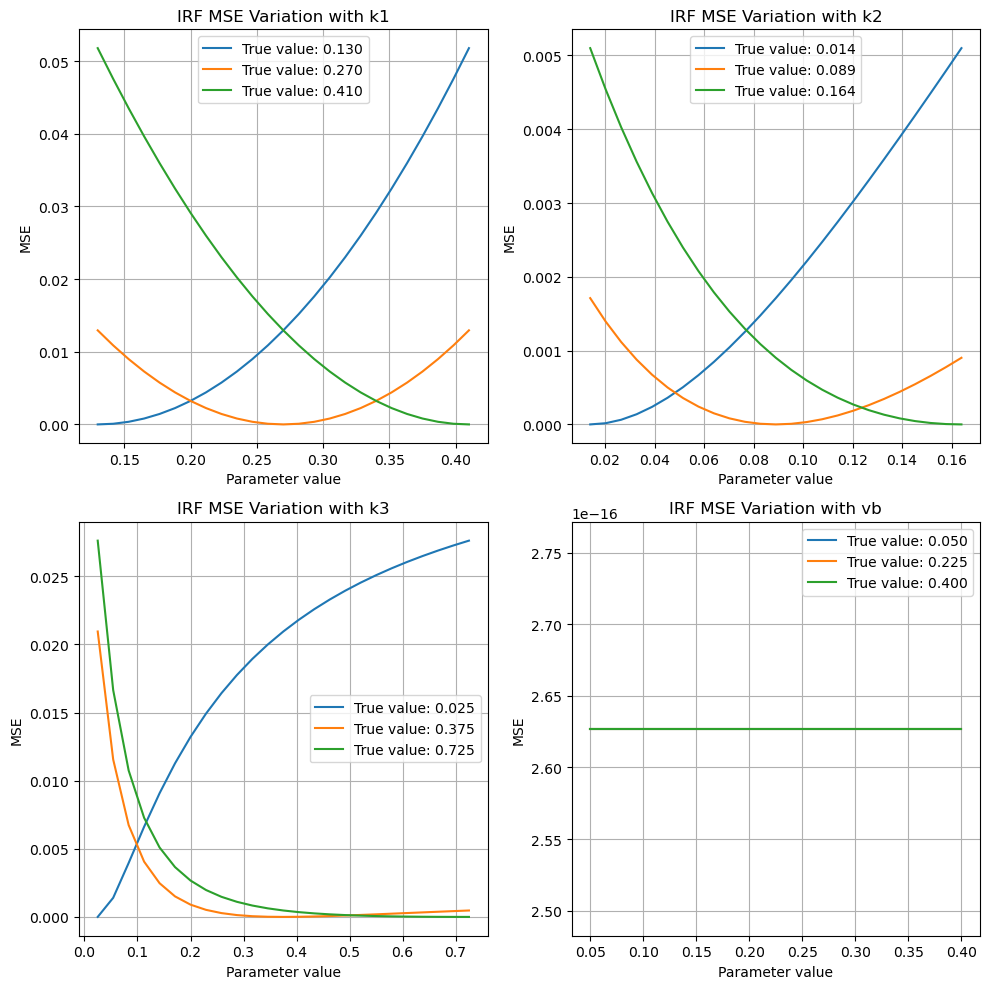

In [13]:
# Define the parameter ranges and parameter names
param_ranges = [
    (0.13, 0.41),   # Range for k1
    (0.014, 0.164), # Range for k2
    (0.025, 0.725), # Range for k3
    (0.05, 0.4)     # Range for vb
]
param_names = ['k1', 'k2', 'k3', 'vb']  # Names of the parameters
num_points = 2048

# Prepare to plot in a 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = axes.flatten()  # Flatten to make indexing easier

# Setup for varying parameters
for i, ((lower, upper), param_name) in enumerate(zip(param_ranges, param_names)):
    param_values = np.linspace(lower, upper, 25)
    # Values to consider as true values: minimum, middle, maximum
    true_values = [lower, (lower + upper) / 2, upper]

    for true_val in true_values:
        mse_values = []
        t_parameters = np.array([0.27, 0.089, 0.375, 0.228])  # Default true parameters
        t_parameters[i] = true_val  # Set the true value for the parameter being tested

        for p_val in param_values:
            p_parameters = t_parameters.copy()
            p_parameters[i] = p_val

            # Calculate the IRF and the loss
            t_irf = torch.tensor(IRF(t_parameters, new_rtim), dtype=torch.float32).unsqueeze(0)
            mse = irf_loss(torch.tensor(p_parameters[np.newaxis, :], dtype=torch.float32), t_irf, num_points)
            mse_values.append(mse)

        # Plotting the results for the current parameter and true value
        label = f'True value: {true_val:.3f}'
        ax = axes[i]
        ax.plot(param_values, mse_values, label=label)

    ax.set_xlabel('Parameter value')
    ax.set_ylabel('MSE')
    ax.set_title(f'IRF MSE Variation with {param_name}')
    ax.grid(True)
    ax.legend()

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

The results show that the loss for each parameter combination is zero when the parameter is the same as its true value, and then increases. The signals are not linear though, and this could be causing trouble with the loss backpropagation. In case of vb the loss is constantly (close-to) zero, since vb has no influence on the IRF calculation. 

<h3>C_Tissue<h3>

Now that the IRF has been verified, we move on to the convolution, which calculates the c-tissue. First we modify the TAC loss function to compare the c-tissue signals. 

In [15]:
def c_tissue_loss(predicted_param, inputs, num_equidistant_points = 2048):
    """
    Calculate the loss between the true and predicted TAC values.

    Parameters:
    true_param (torch.Tensor): True parameter values
    predicted_param (torch.Tensor): Predicted parameter values
    num_equidistant_points (int): Number of equidistant points to interpolate the plasma and blood concentration values

    Returns:
    torch.Tensor: Mean squared error between the true and predicted TAC values
    """
    # Fixed data values
    rtim_list = [0.125, 0.291667, 0.375, 0.458333, 0.583333, 0.75, 0.916667, 1.5, 2.5, 3.5, 4.5, 6.25, 8.75, 12.5, 
                 17.5, 25, 35, 45, 55, 65, 75, 85]
    pl_list = [0.05901, 0.0550587, 110.023, 83.0705, 55.6943, 44.4686, 36.9873, 27.5891, 13.5464, 6.33916, 3.52664, 
               2.49758, 1.44494, 1.04103, 0.71615, 0.52742, 0.43791, 0.35239, 0.32866, 0.27326, 0.26068, 0.24129]
    bl_list = [0.08737, 0.081723, 164.763, 125.181, 84.5654, 68.4428, 58.1711, 44.4919, 24.3138, 14.0272, 9.47834, 
               7.88443, 5.59859, 4.81384, 3.79608, 3.04436, 2.67881, 2.23747, 2.13455, 1.80559, 1.74821, 1.63998]

    # Interpolate plasma and blood concentration values
    new_rtim, _, _, pchip_pl = equidistant_interpolation(rtim_list, pl_list, num_equidistant_points)
    _, _, _, pchip_bl = equidistant_interpolation(rtim_list, bl_list, num_equidistant_points)

    # Convert the interpolated plasma and blood concentration values to PyTorch tensors
    pchip_pl_tensor = torch.tensor(pchip_pl, dtype=torch.float32)
    pchip_bl_tensor = torch.tensor(pchip_bl, dtype=torch.float32)
    new_rtim_tensor = torch.tensor(new_rtim, dtype=torch.float32)

    # Find new_rtim values that are closest to the original time points
    closest_indices = [np.argmin(np.abs(new_rtim - t)) for t in rtim_list]
    
    # Calculate the impulse response functions:
    pred_irf = IRF_torch(predicted_param, new_rtim_tensor)

    # Calculate the C-Tissue values
    dt = new_rtim[1] - new_rtim[0]
    pred_c_tissue = c_tissue_torch(pred_irf, pchip_pl_tensor, dt)

    # # Prints to understand the shapes of the tensors
    # print("pred_c_tissue:", pred_c_tissue.shape)
    # print("pred para:", predicted_param.shape)
    # print("inputs:", inputs.shape)

    # Calculate the simulated TAC values
    pred_tac = simulated_tac_torch(pred_c_tissue, predicted_param, pchip_bl_tensor)

    return nn.MSELoss()(pred_c_tissue, inputs)

original c_tissue shape: torch.Size([2048])
MSE between C_tissue signals: tensor(9.7704e-12)


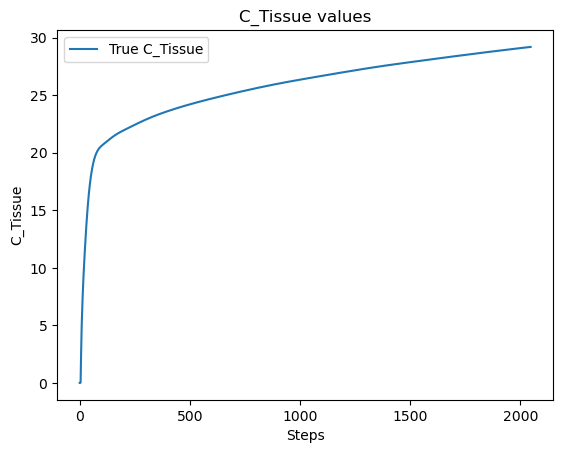

In [21]:
from source.Data_generation import equidistant_interpolation, IRF, c_tissue
rtim_list = [0.125, 0.291667, 0.375, 0.458333, 0.583333, 0.75, 0.916667, 1.5, 2.5, 3.5, 4.5, 6.25, 8.75, 12.5, 
                 17.5, 25, 35, 45, 55, 65, 75, 85]
pl_list = [0.05901, 0.0550587, 110.023, 83.0705, 55.6943, 44.4686, 36.9873, 27.5891, 13.5464, 6.33916, 3.52664, 
               2.49758, 1.44494, 1.04103, 0.71615, 0.52742, 0.43791, 0.35239, 0.32866, 0.27326, 0.26068, 0.24129]
bl_list = [0.08737, 0.081723, 164.763, 125.181, 84.5654, 68.4428, 58.1711, 44.4919, 24.3138, 14.0272, 9.47834, 
               7.88443, 5.59859, 4.81384, 3.79608, 3.04436, 2.67881, 2.23747, 2.13455, 1.80559, 1.74821, 1.63998]
num_equidistant_points = 2048

# Interpolate plasma and blood concentration values
new_rtim, _, _, pchip_pl = equidistant_interpolation(rtim_list, pl_list, num_equidistant_points)
_, _, _, pchip_bl = equidistant_interpolation(rtim_list, bl_list, num_equidistant_points)

p_parameters = np.array([0.27, 0.089, 0.375, 0.228]) # Predicted parameters
t_parameters = np.array([0.27, 0.089, 0.375, 0.228]) # True parameters 
irf = IRF(t_parameters, new_rtim)
dt = new_rtim[1] - new_rtim[0]
c_tissue_values = c_tissue(irf, pchip_pl, dt)

# Plot the c_tissue values
plt.plot(c_tissue_values    )
plt.xlabel("Steps")
plt.ylabel("C_Tissue")
plt.title("C_Tissue values")
plt.legend(["True C_Tissue"])

# Reshape 'parameters' to add a batch dimension
p_parameters_tensor = torch.tensor(p_parameters[np.newaxis, :], dtype=torch.float32)
c_tissue_values_tensor = torch.tensor(c_tissue_values, dtype=torch.float32)
print("original c_tissue shape:", c_tissue_values_tensor.shape)

result = c_tissue_loss(p_parameters_tensor, c_tissue_values_tensor, num_equidistant_points=2048)
print("MSE between C_tissue signals:",result)

We see that the loss here is zero too. 

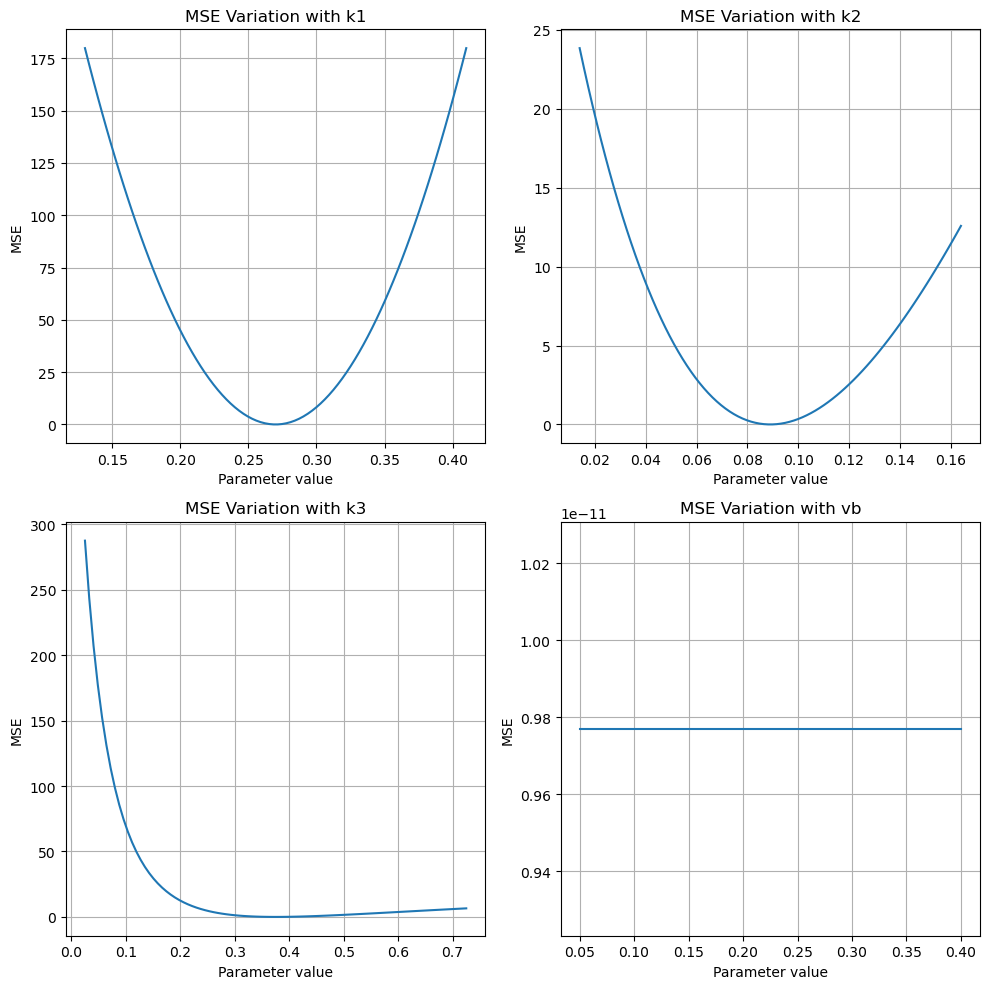

In [25]:
# Define the true parameters and their respective ranges
t_parameters = np.array([0.27, 0.089, 0.375, 0.228])
param_ranges = [
    (0.13, 0.41),   # Range for k1
    (0.014, 0.164), # Range for k2
    (0.025, 0.725), # Range for k3
    (0.05, 0.4)     # Range for vb
]
param_names = ['k1', 'k2', 'k3', 'vb']  # Names of the parameters
num_points = 2048

# Prepare to plot in a 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = axes.flatten()  # Flatten to make indexing easier

# Setup for varying parameters
for i, (true_param, (lower, upper), param_name) in enumerate(zip(t_parameters, param_ranges, param_names)):
    param_values = np.linspace(lower, upper, 90)  # 20 points within each range
    mse_values = []

    for p_val in param_values:
        p_parameters = t_parameters.copy()
        p_parameters[i] = p_val

        t_irf = IRF(t_parameters, new_rtim)
        dt = new_rtim[1] - new_rtim[0]
        c_tissue_values = c_tissue(t_irf, pchip_pl, dt)
        t_c_tissue = torch.tensor(c_tissue_values, dtype=torch.float32)

        mse = c_tissue_loss(torch.tensor(p_parameters[np.newaxis, :], dtype=torch.float32),t_c_tissue , num_points)
        mse_values.append(mse)

    # Plotting the results for the current parameter
    ax = axes[i]
    ax.plot(param_values, mse_values)
    ax.set_xlabel('Parameter value')
    ax.set_ylabel('MSE')
    ax.set_title(f'MSE Variation with {param_name}')
    ax.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()

Seeing that the c_tissue loss is verified, we can now do the same as before and check how it behaves for multiple predicted parameter changes:

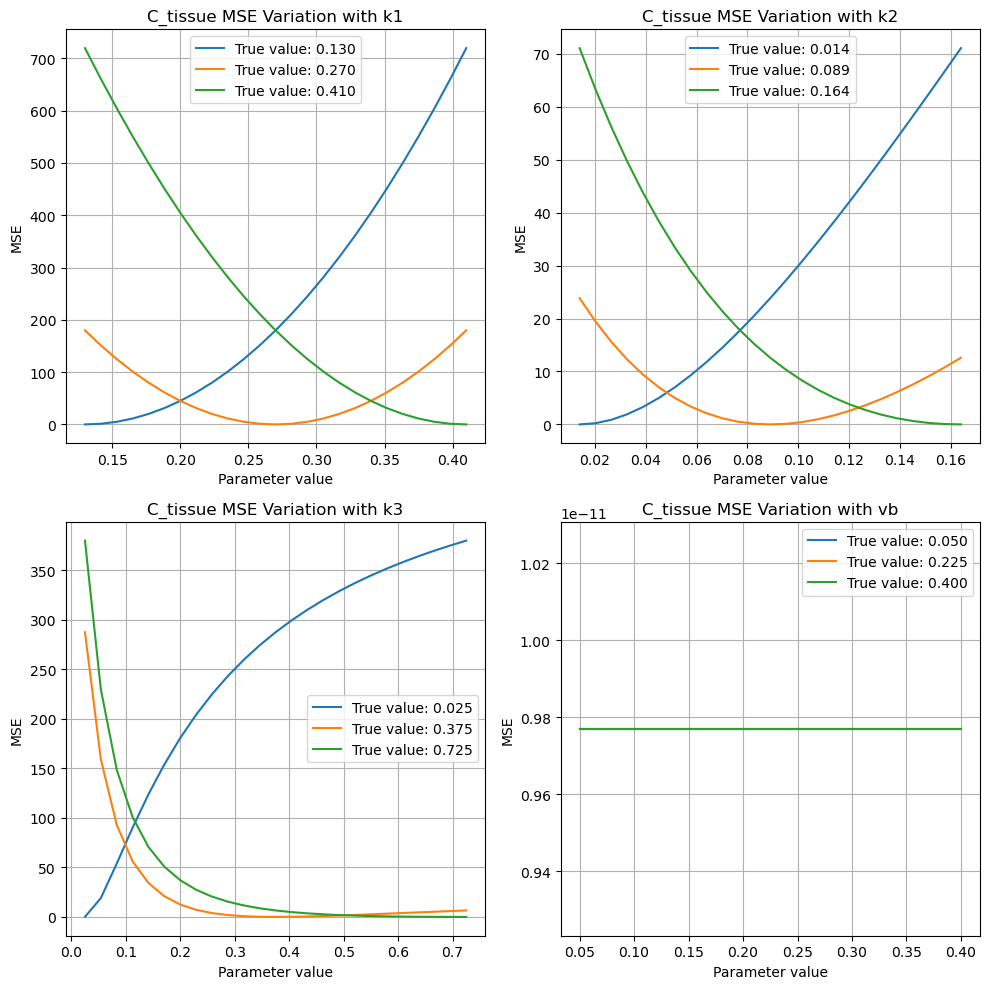

In [22]:
# Define the parameter ranges and parameter names
param_ranges = [
    (0.13, 0.41),   # Range for k1
    (0.014, 0.164), # Range for k2
    (0.025, 0.725), # Range for k3
    (0.05, 0.4)     # Range for vb
]
param_names = ['k1', 'k2', 'k3', 'vb']  # Names of the parameters
num_points = 2048

# Prepare to plot in a 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = axes.flatten()  # Flatten to make indexing easier

# Setup for varying parameters
for i, ((lower, upper), param_name) in enumerate(zip(param_ranges, param_names)):
    param_values = np.linspace(lower, upper, 25)
    # Values to consider as true values: minimum, middle, maximum
    true_values = [lower, (lower + upper) / 2, upper]

    for true_val in true_values:
        mse_values = []
        t_parameters = np.array([0.27, 0.089, 0.375, 0.228])  # Default true parameters
        t_parameters[i] = true_val  # Set the true value for the parameter being tested

        for p_val in param_values:
            p_parameters = t_parameters.copy()
            p_parameters[i] = p_val

            # Calculate the c_tissue and the loss
            t_c_tissue = torch.tensor(c_tissue(IRF(t_parameters, new_rtim), pchip_pl, dt), dtype=torch.float32) # True c_tissue values
            mse = c_tissue_loss(torch.tensor(p_parameters[np.newaxis, :], dtype=torch.float32), t_c_tissue, num_points)
            mse_values.append(mse)

        # Plotting the results for the current parameter and true value
        label = f'True value: {true_val:.3f}'
        ax = axes[i]
        ax.plot(param_values, mse_values, label=label)

    ax.set_xlabel('Parameter value')
    ax.set_ylabel('MSE')
    ax.set_title(f'C_tissue MSE Variation with {param_name}')
    ax.grid(True)
    ax.legend()

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()
    

The curves are the same but the scale is different. I'm not sure it's correct but it could be so: the c_tissue function convolves the IRF with the plasma signal, which has the same shape (but not scale) as the blood signal. 

<h3>TAC<h3>

In [28]:
def tac_loss(predicted_param, inputs, num_equidistant_points = 2048):
    """
    Calculate the loss between the true and predicted TAC values.

    Parameters:
    true_param (torch.Tensor): True parameter values
    predicted_param (torch.Tensor): Predicted parameter values
    num_equidistant_points (int): Number of equidistant points to interpolate the plasma and blood concentration values

    Returns:
    torch.Tensor: Mean squared error between the true and predicted TAC values
    """
    # Fixed data values
    rtim_list = [0.125, 0.291667, 0.375, 0.458333, 0.583333, 0.75, 0.916667, 1.5, 2.5, 3.5, 4.5, 6.25, 8.75, 12.5, 
                 17.5, 25, 35, 45, 55, 65, 75, 85]
    pl_list = [0.05901, 0.0550587, 110.023, 83.0705, 55.6943, 44.4686, 36.9873, 27.5891, 13.5464, 6.33916, 3.52664, 
               2.49758, 1.44494, 1.04103, 0.71615, 0.52742, 0.43791, 0.35239, 0.32866, 0.27326, 0.26068, 0.24129]
    bl_list = [0.08737, 0.081723, 164.763, 125.181, 84.5654, 68.4428, 58.1711, 44.4919, 24.3138, 14.0272, 9.47834, 
               7.88443, 5.59859, 4.81384, 3.79608, 3.04436, 2.67881, 2.23747, 2.13455, 1.80559, 1.74821, 1.63998]

    # Interpolate plasma and blood concentration values
    new_rtim, _, _, pchip_pl = equidistant_interpolation(rtim_list, pl_list, num_equidistant_points)
    _, _, _, pchip_bl = equidistant_interpolation(rtim_list, bl_list, num_equidistant_points)

    # Convert the interpolated plasma and blood concentration values to PyTorch tensors
    pchip_pl_tensor = torch.tensor(pchip_pl, dtype=torch.float32)
    pchip_bl_tensor = torch.tensor(pchip_bl, dtype=torch.float32)
    new_rtim_tensor = torch.tensor(new_rtim, dtype=torch.float32)

    # Find new_rtim values that are closest to the original time points
    closest_indices = [np.argmin(np.abs(new_rtim - t)) for t in rtim_list]
    
    # Calculate the impulse response functions:
    pred_irf = IRF_torch(predicted_param, new_rtim_tensor)

    # Calculate the C-Tissue values
    dt = new_rtim[1] - new_rtim[0]
    pred_c_tissue = c_tissue_torch(pred_irf, pchip_pl_tensor, dt)

    # # Prints to understand the shapes of the tensors
    # print("pred_c_tissue:", pred_c_tissue.shape)
    # print("pred para:", predicted_param.shape)
    # print("inputs:", inputs.shape)

    # Calculate the simulated TAC values
    pred_tac = simulated_tac_torch(pred_c_tissue, predicted_param, pchip_bl_tensor)

    return nn.MSELoss()(pred_tac, inputs)

original c_tissue shape: torch.Size([1, 2048])
MSE between TAC signals: tensor(8.0522e-12)


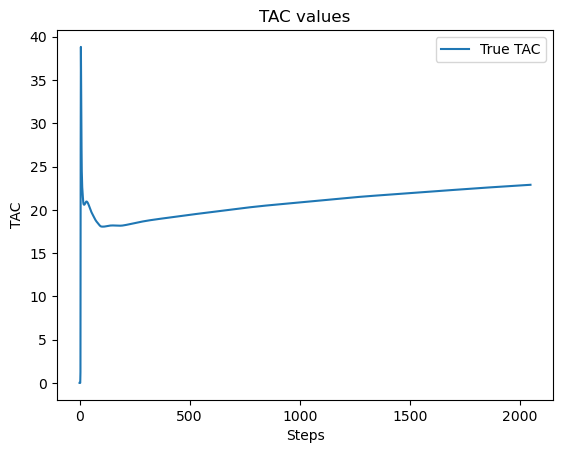

In [29]:
from source.Data_generation import equidistant_interpolation, IRF, c_tissue
rtim_list = [0.125, 0.291667, 0.375, 0.458333, 0.583333, 0.75, 0.916667, 1.5, 2.5, 3.5, 4.5, 6.25, 8.75, 12.5, 
                 17.5, 25, 35, 45, 55, 65, 75, 85]
pl_list = [0.05901, 0.0550587, 110.023, 83.0705, 55.6943, 44.4686, 36.9873, 27.5891, 13.5464, 6.33916, 3.52664, 
               2.49758, 1.44494, 1.04103, 0.71615, 0.52742, 0.43791, 0.35239, 0.32866, 0.27326, 0.26068, 0.24129]
bl_list = [0.08737, 0.081723, 164.763, 125.181, 84.5654, 68.4428, 58.1711, 44.4919, 24.3138, 14.0272, 9.47834, 
               7.88443, 5.59859, 4.81384, 3.79608, 3.04436, 2.67881, 2.23747, 2.13455, 1.80559, 1.74821, 1.63998]
num_equidistant_points = 2048

# Interpolate plasma and blood concentration values
new_rtim, _, _, pchip_pl = equidistant_interpolation(rtim_list, pl_list, num_equidistant_points)
_, _, _, pchip_bl = equidistant_interpolation(rtim_list, bl_list, num_equidistant_points)

p_parameters = np.array([0.27, 0.089, 0.375, 0.228]) # Predicted parameters
t_parameters = np.array([0.27, 0.089, 0.375, 0.228]) # True parameters 
irf = IRF(t_parameters, new_rtim)
dt = new_rtim[1] - new_rtim[0]
c_tissue_values = c_tissue(irf, pchip_pl, dt)
tac_values = simulated_tac(c_tissue_values, t_parameters, pchip_bl)

# Plot the c_tissue values
plt.plot(tac_values)
plt.xlabel("Steps")
plt.ylabel("TAC")
plt.title("TAC values")
plt.legend(["True TAC"])

# Reshape 'parameters' to add a batch dimension
p_parameters_tensor = torch.tensor(p_parameters[np.newaxis, :], dtype=torch.float32)
tac_values_tensor = torch.tensor(tac_values, dtype=torch.float32).unsqueeze(0)
print("original c_tissue shape:", tac_values_tensor.shape)

result = tac_loss(p_parameters_tensor, tac_values_tensor, num_equidistant_points=2048)
print("MSE between TAC signals:",result)

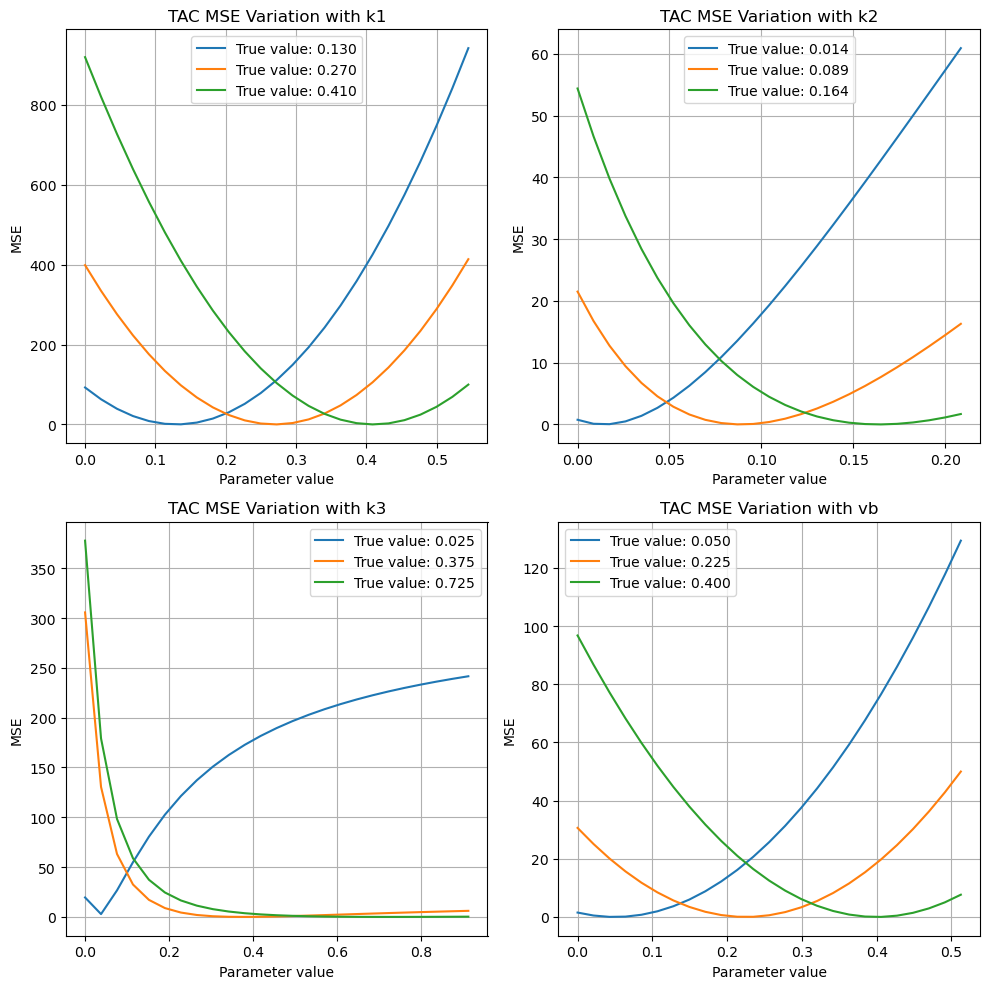

In [38]:
# Define the parameter ranges and parameter names
param_ranges = [
    (0.13, 0.41),   # Range for k1
    (0.014, 0.164), # Range for k2
    (0.025, 0.725), # Range for k3
    (0.05, 0.4)     # Range for vb
]
param_names = ['k1', 'k2', 'k3', 'vb']  # Names of the parameters
num_points = 2048
margin = 0.5

# Prepare to plot in a 2x2 grid
fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = axes.flatten()  # Flatten to make indexing easier

# Setup for varying parameters
for i, ((lower, upper), param_name) in enumerate(zip(param_ranges, param_names)):
    median = (lower + upper) / 2
    #param_values = np.linspace(lower - median*margin, upper + median*margin, 25)
    param_values = np.linspace(0, upper + median*margin, 25)
    # Values to consider as true values: minimum, middle, maximum
    true_values = [lower, median, upper]

    for true_val in true_values:
        mse_values = []
        t_parameters = np.array([0.27, 0.089, 0.375, 0.228])  # Default true parameters
        t_parameters[i] = true_val  # Set the true value for the parameter being tested

        for p_val in param_values:
            p_parameters = t_parameters.copy()
            p_parameters[i] = p_val

            # Calculate the tac and the loss
            t_c_tissue = c_tissue(IRF(t_parameters, new_rtim), pchip_pl, dt)
            t_tac_tissue = torch.tensor(simulated_tac(t_c_tissue, t_parameters, pchip_bl), dtype=torch.float32).unsqueeze(0) # True tac values
            mse = tac_loss(torch.tensor(p_parameters[np.newaxis, :], dtype=torch.float32), t_tac_tissue, num_points)
            mse_values.append(mse)

        # Plotting the results for the current parameter and true value
        label = f'True value: {true_val:.3f}'
        ax = axes[i]
        ax.plot(param_values, mse_values, label=label)

    ax.set_xlabel('Parameter value')
    ax.set_ylabel('MSE')
    ax.set_title(f'TAC MSE Variation with {param_name}')
    ax.grid(True)
    ax.legend()

# Adjust layout to prevent overlap
plt.tight_layout()
plt.show()